In [1]:
import torch
train_dir = "PlantDataset/train"
test_dir = "PlantDataset/test"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(72),                                      
    transforms.RandomCrop(64),                                  
    transforms.RandomHorizontalFlip(p=0.5),                     
    transforms.RandomRotation(15),                              
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), 
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.2), 
    transforms.ToTensor(),                                     
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))    
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),                               
    transforms.ToTensor(),                                      
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))     
])

In [3]:
from torchvision import datasets, transforms
train_data = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)

In [4]:
num_classes = len(train_data.classes)

In [5]:
from tuningmodel import CustomCNN

model = CustomCNN(num_classes,dropout_conv=0.20274887191676094,dropout_fc=0.32760082109803323)
model.to(device)

CustomCNN(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.20274887191676094, inplace=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.20274887191676094, inplace=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [6]:
# model = CustomCNN(15).cuda()
# batch_size=2
# n = 1

# while(True):
#     try:
#         dummy_input = torch.randn(batch_size, 3, 64, 64).cuda()
#         output = model(dummy_input)
#         print(f"Batch size {batch_size} fits in GPU memory!")
#     except RuntimeError as e:
#         if 'out of memory' in str(e):
#             print(f"Batch size {batch_size} too large!")
#             break
#         else:
#             raise e
#     n+=1
#     batch_size = 2**(n)

In [7]:
from torch.utils.data import DataLoader
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [8]:
class_names = train_data.classes
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [9]:
from torchinfo import summary

summary(model=model,
        input_size=(512,3,64,64),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"],
        device=str(device)  # Ensure summary runs on the same device as the model
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
CustomCNN (CustomCNN)                    [512, 3, 64, 64]     [512, 15]            --                   True
├─Sequential (conv_block1)               [512, 3, 64, 64]     [512, 32, 21, 21]    --                   True
│    └─Conv2d (0)                        [512, 3, 64, 64]     [512, 32, 64, 64]    896                  True
│    └─BatchNorm2d (1)                   [512, 32, 64, 64]    [512, 32, 64, 64]    64                   True
│    └─ReLU (2)                          [512, 32, 64, 64]    [512, 32, 64, 64]    --                   --
│    └─MaxPool2d (3)                     [512, 32, 64, 64]    [512, 32, 21, 21]    --                   --
│    └─Dropout (4)                       [512, 32, 21, 21]    [512, 32, 21, 21]    --                   --
├─Sequential (conv_block2)               [512, 32, 21, 21]    [512, 64, 10, 10]    --                   True
│    └─Conv2d (0)   

In [10]:
from torch import nn
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0006324336252474491, weight_decay=2.7909484353670146e-06)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [11]:
from trainNN import train

torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()


In [12]:
# Get one batch of images and labels
images, labels = next(iter(train_loader))

# Print shape of images
print(images.shape)  # Output: [batch_size, channels, height, width]


torch.Size([64, 3, 64, 64])


In [13]:
results = train(
            model=model,
            train_dataloader=train_loader,
            test_dataloader=test_loader,
            optimizer=optimizer,
            loss_fn=criterion,
            epochs=50,
            device=device,
            scheduler=scheduler
)

end_time = timer()
print(f"[INFO] Total training time: {(end_time-start_time)/60:.3f} minutes")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2315 | train_acc: 0.6006 | test_loss: 1.1019 | test_acc: 0.6582
Current LR: 0.000632
Epoch: 2 | train_loss: 0.6945 | train_acc: 0.7681 | test_loss: 0.5571 | test_acc: 0.8113
Current LR: 0.000632
Epoch: 3 | train_loss: 0.5195 | train_acc: 0.8258 | test_loss: 0.5062 | test_acc: 0.8373
Current LR: 0.000632
Epoch: 4 | train_loss: 0.4344 | train_acc: 0.8533 | test_loss: 0.4017 | test_acc: 0.8637
Current LR: 0.000632
Epoch: 5 | train_loss: 0.3928 | train_acc: 0.8692 | test_loss: 0.3124 | test_acc: 0.8972
Current LR: 0.000632
Epoch: 6 | train_loss: 0.3330 | train_acc: 0.8862 | test_loss: 0.2468 | test_acc: 0.9179
Current LR: 0.000632
Epoch: 7 | train_loss: 0.3074 | train_acc: 0.8962 | test_loss: 0.2156 | test_acc: 0.9296
Current LR: 0.000632
Epoch: 8 | train_loss: 0.2835 | train_acc: 0.9054 | test_loss: 0.2435 | test_acc: 0.9144
Current LR: 0.000632
Epoch: 9 | train_loss: 0.2562 | train_acc: 0.9122 | test_loss: 0.2982 | test_acc: 0.9005
Current LR: 0.000632
Epoch: 10 

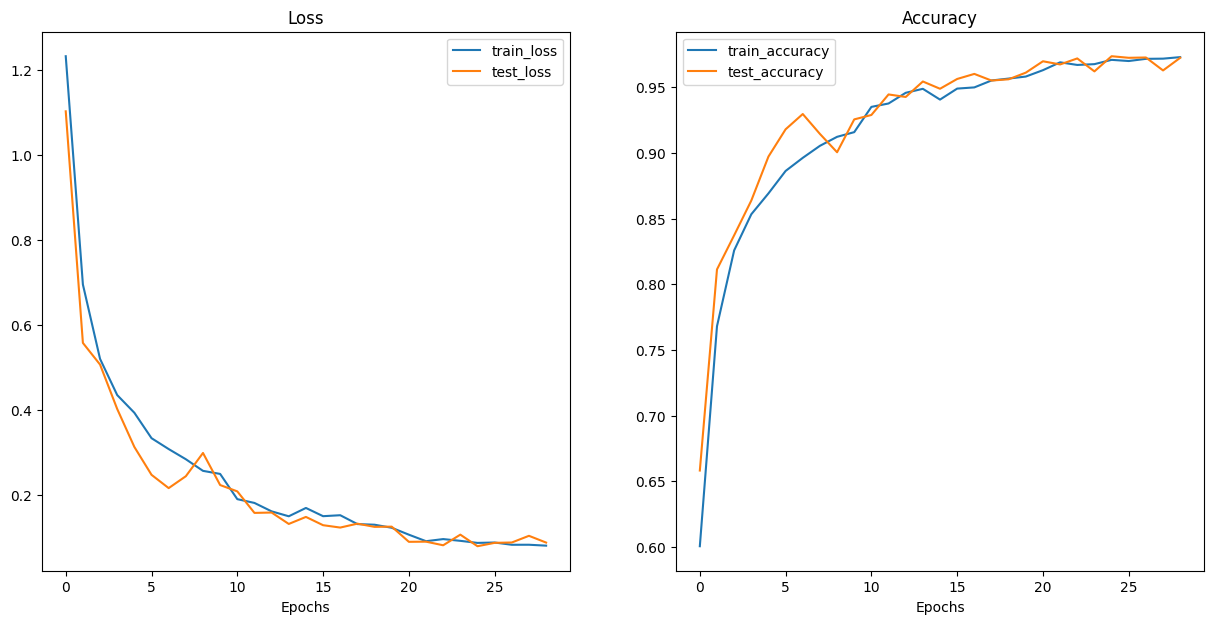

In [14]:
from helper_functions import plot_loss_curves
plot_loss_curves(results)

In [15]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "modeldrop_final.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving model to models\modeldrop_final.pth
